## Dataset loading using braindecode

In [1]:
import braindecode

<frozen importlib._bootstrap>:219: FutureWarning: mne.io.pick.pick_types is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.
<frozen importlib._bootstrap>:219: FutureWarning: mne.io.pick.pick_channels_regexp is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.
<frozen importlib._bootstrap>:219: FutureWarning: mne.io.pick.channel_type is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.
c:\Users\Sam\miniconda3\envs\pytgpu\lib\site-packages\moabb\pipelines\__init__.py:26: ModuleNotFoundError: Tensorflow is not installed. You won't be able to use these MOABB pipelines if you attempt to do so.
  warn(


In [2]:
import torch
from braindecode.models import EEGNetv4, EEGConformer, ATCNet, EEGITNet, EEGInception
from braindecode.datasets import MOABBDataset

In [3]:
raw_dataset = MOABBDataset(dataset_name="BNCI2014_001", subject_ids=None)

Preprocess dataset using braindecode API

In [4]:
from braindecode.preprocessing import create_windows_from_events
from braindecode.preprocessing import exponential_moving_standardize, preprocess, Preprocessor

In [ ]:
# low_freq = 4
# high_freq = 38
# resample_freq = 250

# # preprocess data using "braindecode.preprocessor"
# # only use eeg(stim channels must be removed)
# preprocessors = [Preprocessor('pick', picks=['eeg'])]

# # if pick_channels:
# #     preprocessors.append(Preprocessor('pick', picks=pick_channels))
# # preprocessors.append(Preprocessor(lambda data: multiply(data, 1e6)))


# # if low_freq or high_freq:
#     # preprocessors.append(Preprocessor('filter', l_freq=low_freq, h_freq=high_freq))
# if resample_freq:
#     preprocessors.append(Preprocessor('resample', sfreq=resample_freq))
# preprocessors.append(Preprocessor(exponential_moving_standardize, factor_new=1e-3))
# preprocess(raw_dataset, preprocessors)

# from braindecode.preprocessing import MNEPreproc, NumpyPreproc, preprocess

low_cut_hz = 4.  # low cut frequency for filtering
high_cut_hz = 38.  # high cut frequency for filtering
# Parameters for exponential moving standardization
factor_new = 1e-3
init_block_size = 1000

preprocessors = [
    # keep only EEG sensors
    Preprocessor(fn='pick_types', eeg=True, meg=False, stim=False),
    # convert from volt to microvolt, directly modifying the numpy array
    Preprocessor(fn=lambda x: x * 1e6),
    # bandpass filter
    Preprocessor(fn='filter', l_freq=low_cut_hz, h_freq=high_cut_hz),
    # exponential moving standardization
    Preprocessor(fn=exponential_moving_standardize, factor_new=factor_new,
        init_block_size=init_block_size)
]

# Preprocess the data
preprocess(raw_dataset, preprocessors)

Window Split (for each trail start and end)

In [9]:
start_offset = -0.5
stop_offset = 0

sfreq = raw_dataset.datasets[0].raw.info['sfreq']
#assert all([ds.raw.info['sfreq'] == sfreq for ds in raw_dataset.datasets])
trial_start_offset_samples = int(start_offset * sfreq)
trial_stop_offset_samples = int(stop_offset * sfreq)

windows_dataset = create_windows_from_events(
    raw_dataset,
    trial_start_offset_samples,
    trial_stop_offset_samples,
    preload=True,
)

Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']

In [10]:
import pandas as pd
df = pd.DataFrame(windows_dataset.get_metadata())
df.to_csv('windows_dataset.csv')
windows_dataset.get_metadata()

,i_window_in_trial,i_start_in_trial,i_stop_in_trial,target,subject,session,run
0,0,125,1250,3,1,0train,0
1,0,2128,3253,0,1,0train,0
2,0,4046,5171,2,1,0train,0
3,0,5998,7123,1,1,0train,0
4,0,8006,9131,1,1,0train,0
...,...,...,...,...,...,...,...
43,0,86625,87750,0,9,1test,5
44,0,88531,89656,3,9,1test,5
45,0,90459,91584,0,9,1test,5
46,0,92573,93698,1,9,1test,5


In [11]:
import numpy as np

In [12]:
meta_windows = windows_dataset.get_metadata()
np.unique(meta_windows['session'], return_counts = True)

(array(['0train', '1test'], dtype=object), array([2592, 2592], dtype=int64))

Get additional dataset details and set model configuration

In [13]:
n_channels = raw_dataset[0][0].shape[0]
n_times = windows_dataset[0][0].shape[1]
n_classes = 4 # number of classes in the dataset used

n_epochs = 6
lr = 0.001
batch_size = 64

# variables to save the model
save = 'store_true'
save_dir = 'models/'
strategy = 'within-subject' # 'within-subject' or 'cross-subject'
model_name = 'EEGNet' # 'EEGNet', 'EEGConformer', 'ATCNet', 'EEGITNet', 'EEGInception'
verbose = 2

Split data  into test and train based on window subset

In [14]:
from skorch.helper import SliceDataset
from skorch.callbacks import LRScheduler, TrainEndCheckpoint
from skorch import NeuralNetClassifier

cuda = torch.cuda.is_available()


In [15]:
X = []
y = []
for i in range(len(windows_dataset)):
    x, target, window_ind = windows_dataset[i]
    # print(f"Shape of window {i}: {x.shape}, Label: {target}")
    X.append(x)
    y.append(target)

In [16]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split


In [17]:
X = np.array(X)
enc = OneHotEncoder()
y = enc.fit_transform(np.array(y).reshape(-1,1)).toarray()

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=16)

In [19]:
X_train.shape

(3628, 22, 1125)

In [20]:
y_train.shape

(3628, 4)

In [18]:
np.unique(np.argmax(y_test, axis=1),return_counts=True)

(array([0, 1, 2, 3], dtype=int64), array([404, 359, 390, 403], dtype=int64))

In [19]:
np.unique(np.argmax(y_train, axis=1),return_counts=True)

(array([0, 1, 2, 3], dtype=int64), array([892, 937, 906, 893], dtype=int64))

In [21]:
from sklearn.metrics import *
from sklearn.model_selection import ShuffleSplit
import matplotlib.pyplot as plt

In [23]:
cv = ShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 16)

In [22]:
def CV_train(model, X, X_test, cnn = False, convlstm = False, batch_size = 32, n_epochs = 50, y_out = y_train, y_out_test = y_test):
    acc = []
    f1 = []
    prec = []
    recall = []
    results = {}
    best_model = model
    prev_metric = 0
    best_hist = []
    for train_idx, val_idx in cv.split(y_out):

        nn = [] 

        label_train, _ = y_out[train_idx], y_out[val_idx]
        y_train, y_val = y_out[train_idx], y_out[val_idx] 

        X_train = X[train_idx] 
        X_val = X[val_idx] 
        
        if cnn:
            X_train = np.expand_dims(X_train,-1)
        elif convlstm:
            X_train = np.expand_dims(np.expand_dims(X_train, -1),-1)

        nn = model

        history = nn.fit(X_train, y_train, validation_data = (X_val, y_val), batch_size = batch_size, epochs = n_epochs)

        y_pred = nn.predict(X_val)
        pred = (y_pred == y_pred.max(axis=1)[:,None]).astype(int)

        acc_score = accuracy_score(y_val.argmax(axis=1), pred.argmax(axis=1))
        acc.append(acc_score)
        f1_val = (f1_score(y_val.argmax(axis=1), pred.argmax(axis=1), average='weighted'))
        f1.append(f1_val)
        prec.append(precision_score(y_val.argmax(axis=1), pred.argmax(axis=1),average='weighted'))
        recall.append(recall_score(y_val.argmax(axis=1), pred.argmax(axis=1),average='weighted'))
        if f1_val > prev_metric: 
            prev_metric = f1_val
            best_model = model
            best_hist = history
    
    test_pred = best_model.predict(X_test)
    pred = (test_pred == test_pred.max(axis=1)[:,None]).astype(int)
    acc.append(accuracy_score(y_out_test.argmax(axis=1), pred.argmax(axis=1)))
    f1.append(f1_score(y_out_test.argmax(axis=1), pred.argmax(axis=1), average='weighted'))
    prec.append(precision_score(y_out_test.argmax(axis=1), pred.argmax(axis=1),average='weighted'))
    recall.append(recall_score(y_out_test.argmax(axis=1), pred.argmax(axis=1),average='weighted'))
    
    results['Accuracy'] = acc
    results['F1'] = f1
    results['Precision'] = prec
    results['Recall'] = recall

    plt.plot(best_hist.history['loss'], label='Training Loss')
    plt.plot(best_hist.history['val_loss'], label='Validation Loss', color = 'b')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()
    plt.plot(best_hist.history['accuracy'], label='Training Accuracy')
    plt.plot(best_hist.history['val_accuracy'], label='Validation Accuracy', color = 'b')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

    return best_model, results

In [24]:
import mne 
import numpy as np
import pandas as pd
import torch
import os
import braindecode
import matplotlib.pyplot as plt
from braindecode.models import EEGNetv4, EEGConformer, ATCNet, EEGITNet, EEGInception
from braindecode.datasets import MOABBDataset
from braindecode.preprocessing import create_windows_from_events
from braindecode.preprocessing import exponential_moving_standardize, preprocess, Preprocessor

import scipy.io
import pywt
from mne.decoding import CSP # Common Spatial Pattern Filtering
from sklearn.preprocessing import OneHotEncoder
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten, Reshape, ConvLSTM1D, Conv2D
from keras import regularizers
from sklearn import preprocessing
from sklearn.metrics import *
from sklearn.model_selection import ShuffleSplit

In [25]:
def build_mlp_classifier(num_layers = 1, lr = 0.01):
    classifier = Sequential()
    classifier.add(Flatten())
    #First Layer
    classifier.add(Dense(units = 256, kernel_initializer = 'uniform', activation = 'relu', 
                         kernel_regularizer=regularizers.l2(0.01))) # L2 regularization
    classifier.add(Dropout(0.4))
    # Intermediate Layers
    for itr in range(num_layers):
        classifier.add(Dense(units = 128, kernel_initializer = 'uniform', activation = 'relu', 
                             kernel_regularizer=regularizers.l2(0.01))) # L2 regularization
        classifier.add(Dropout(0.4))   
    # Last Layer
    classifier.add(Dense(units = 4, kernel_initializer = 'uniform', activation = 'softmax'))
    classifier.compile(optimizer = keras.optimizers.Adam(lr=lr) , loss = 'categorical_crossentropy', metrics = ['accuracy'])
    return classifier

c:\Users\Sam\miniconda3\envs\pytgpu\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/2
91/91 [==============================] - 4s 30ms/step - loss: 42.5893 - accuracy: 0.2588 - val_loss: 31.7857 - val_accuracy: 0.2713
Epoch 2/2
25/49 [==============>...............] - ETA: 0s

c:\Users\Sam\miniconda3\envs\pytgpu\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


49/49 [==============================] - 0s 5ms/step


c:\Users\Sam\miniconda3\envs\pytgpu\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


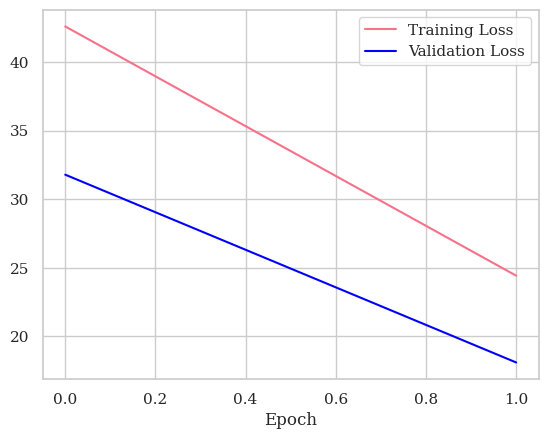

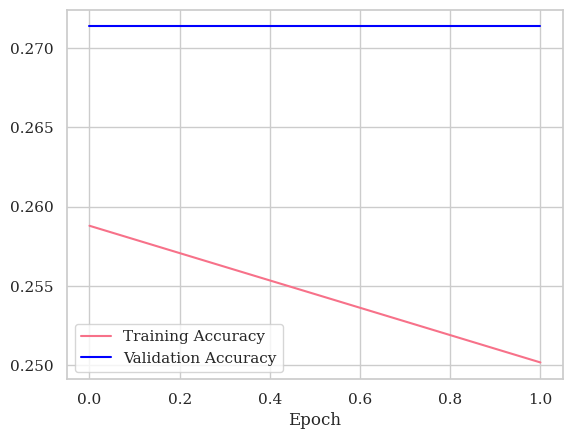

In [26]:
mlp = build_mlp_classifier(5, 0.0001)
mlp, mlp_results = CV_train(mlp, X_train, X_test, n_epochs=2)

In [27]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Permute, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import SeparableConv2D, DepthwiseConv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import SpatialDropout2D
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import backend as K

In [28]:
def build_eegnet_classifier(nb_classes=4, Chans = 22, Samples = 1125, 
             dropoutRate = 0.3, kernLength = 64, F1 = 8, 
             D = 2, F2 = 16, norm_rate = 0.25, dropoutType = 'Dropout'):
    
    if dropoutType == 'SpatialDropout2D':
        dropoutType = SpatialDropout2D
    elif dropoutType == 'Dropout':
        dropoutType = Dropout
    else:
        raise ValueError('dropoutType must be one of SpatialDropout2D '
                         'or Dropout, passed as a string.')
    
    input1   = Input(shape = (Chans, Samples, 1))

    ##################################################################
    block1       = Conv2D(F1, (1, kernLength), padding = 'same',
                                   input_shape = (Chans, Samples, 1),
                                   use_bias = False)(input1)
    block1       = BatchNormalization()(block1)
    block1       = DepthwiseConv2D((Chans, 1), use_bias = False, 
                                   depth_multiplier = D,
                                   depthwise_constraint = max_norm(1.))(block1)
    block1       = BatchNormalization()(block1)
    block1       = Activation('elu')(block1)
    block1       = AveragePooling2D((1, 4))(block1)
    block1       = dropoutType(dropoutRate)(block1)
    
    block2       = SeparableConv2D(F2, (1, 16),
                                   use_bias = False, padding = 'same')(block1)
    block2       = BatchNormalization()(block2)
    block2       = Activation('elu')(block2)
    block2       = AveragePooling2D((1, 8))(block2)
    block2       = dropoutType(dropoutRate)(block2)
        
    flatten      = Flatten(name = 'flatten')(block2)
    
    dense        = Dense(nb_classes, name = 'dense', 
                         kernel_constraint = max_norm(norm_rate))(flatten)
    softmax      = Activation('softmax', name = 'softmax')(dense)
    classifier = Model(inputs=input1, outputs=softmax)
    classifier.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
    return classifier

In [29]:
X_train.shape

(3628, 22, 1125)

Epoch 1/2
91/91 [==============================] - 17s 156ms/step - loss: 1.3700 - accuracy: 0.2981 - val_loss: 1.3770 - val_accuracy: 0.2851
Epoch 2/2
49/49 [==============================] - 1s 18ms/step


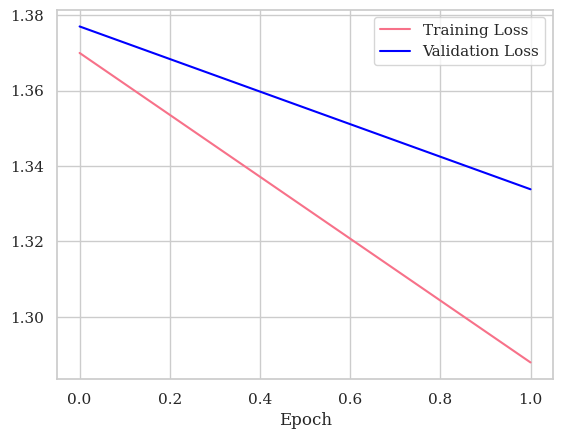

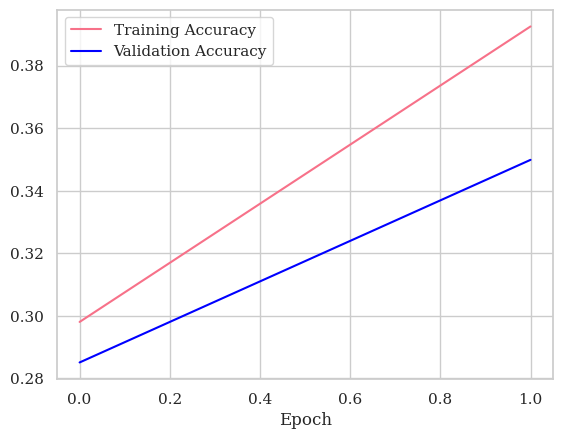

In [30]:
eegnet = build_eegnet_classifier()
eegnet, eegnet_results = CV_train(eegnet, np.expand_dims(X_train,-1), np.expand_dims(X_test,-1), n_epochs=2)

In [31]:
def square(x):
    return K.square(x)

def log(x):
    return K.log(K.clip(x, min_value = 1e-7, max_value = 10000)) 


In [32]:
def build_shallow_conv_net(nb_classes=4, Chans = 22, Samples = 1125, dropoutRate = 0.5):
    # start the model
    input_main   = Input((Chans, Samples, 1))
    block1       = Conv2D(40, (1, 13), 
                        input_shape=(Chans, Samples, 1),
                        kernel_constraint = max_norm(2., axis=(0,1,2)))(input_main)
    block1       = Conv2D(40, (Chans, 1), use_bias=False, 
                          kernel_constraint = max_norm(2., axis=(0,1,2)))(block1)
    block1       = BatchNormalization(epsilon=1e-05, momentum=0.9)(block1)
    block1       = Activation(square)(block1)
    block1       = AveragePooling2D(pool_size=(1, 35), strides=(1, 7))(block1)
    block1       = Activation(log)(block1)
    block1       = Dropout(dropoutRate)(block1)
    flatten      = Flatten()(block1)
    dense        = Dense(nb_classes, kernel_constraint = max_norm(0.5))(flatten)
    softmax      = Activation('softmax')(dense)
    return Model(inputs=input_main, outputs=softmax)

c:\Users\Sam\miniconda3\envs\pytgpu\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


49/49 [==============================] - 2s 33ms/step


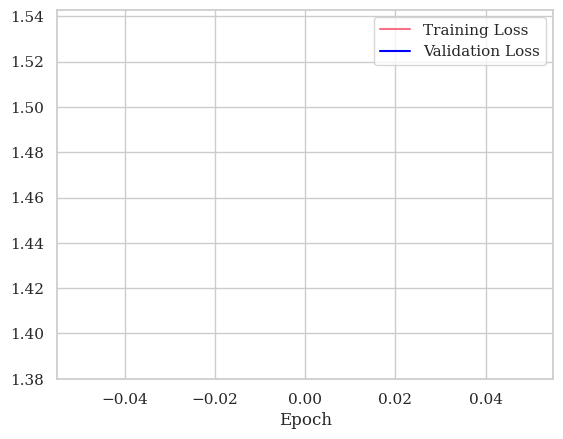

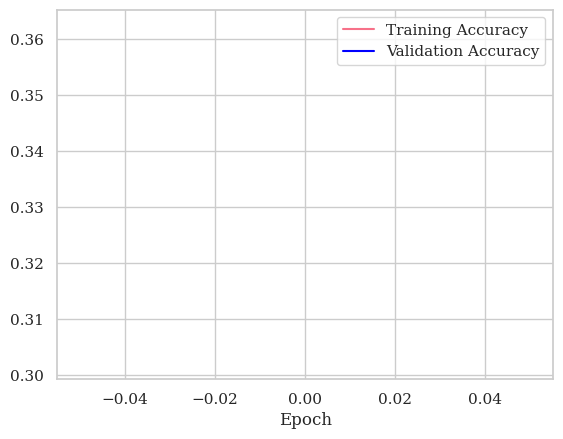

In [33]:
scn = build_shallow_conv_net()
scn.compile(optimizer=keras.optimizers.Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
scn, scn_results = CV_train(scn, np.expand_dims(X_train,-1), np.expand_dims(X_test,-1), n_epochs=1)

In [34]:
def build_deep_conv_net(nb_classes=4, Chans = 22, Samples = 1125, dropoutRate = 0.5):
    # start the model
    input_main   = Input((Chans, Samples, 1))
    block1       = Conv2D(25, (1, 5), 
                                 input_shape=(Chans, Samples, 1),
                                 kernel_constraint = max_norm(2., axis=(0,1,2)))(input_main)
    block1       = Conv2D(25, (Chans, 1),
                                 kernel_constraint = max_norm(2., axis=(0,1,2)))(block1)
    block1       = BatchNormalization(epsilon=1e-05, momentum=0.9)(block1)
    block1       = Activation('elu')(block1)
    block1       = MaxPooling2D(pool_size=(1, 2), strides=(1, 2))(block1)
    block1       = Dropout(dropoutRate)(block1)
  
    block2       = Conv2D(50, (1, 5),
                                 kernel_constraint = max_norm(2., axis=(0,1,2)))(block1)
    block2       = BatchNormalization(epsilon=1e-05, momentum=0.9)(block2)
    block2       = Activation('elu')(block2)
    block2       = MaxPooling2D(pool_size=(1, 2), strides=(1, 2))(block2)
    block2       = Dropout(dropoutRate)(block2)
    
    block3       = Conv2D(100, (1, 5),
                                 kernel_constraint = max_norm(2., axis=(0,1,2)))(block2)
    block3       = BatchNormalization(epsilon=1e-05, momentum=0.9)(block3)
    block3       = Activation('elu')(block3)
    block3       = MaxPooling2D(pool_size=(1, 2), strides=(1, 2))(block3)
    block3       = Dropout(dropoutRate)(block3)
    
    block4       = Conv2D(200, (1, 5),
                                 kernel_constraint = max_norm(2., axis=(0,1,2)))(block3)
    block4       = BatchNormalization(epsilon=1e-05, momentum=0.9)(block4)
    block4       = Activation('elu')(block4)
    block4       = MaxPooling2D(pool_size=(1, 2), strides=(1, 2))(block4)
    block4       = Dropout(dropoutRate)(block4)
    
    flatten      = Flatten()(block4)
    
    dense        = Dense(nb_classes, kernel_constraint = max_norm(0.5))(flatten)
    softmax      = Activation('softmax')(dense)
    
    return Model(inputs=input_main, outputs=softmax)

c:\Users\Sam\miniconda3\envs\pytgpu\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


 3/49 [>.............................] - ETA: 1s

c:\Users\Sam\miniconda3\envs\pytgpu\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


49/49 [==============================] - 2s 38ms/step


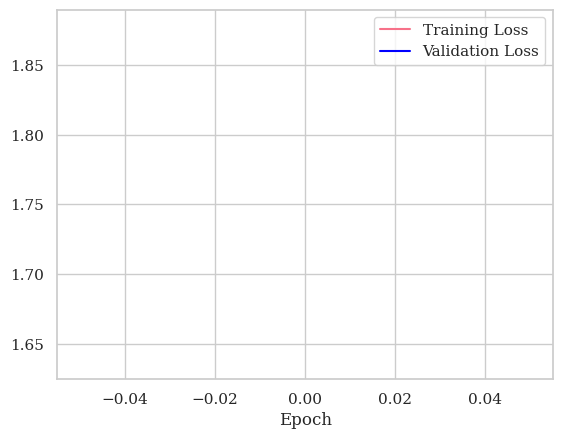

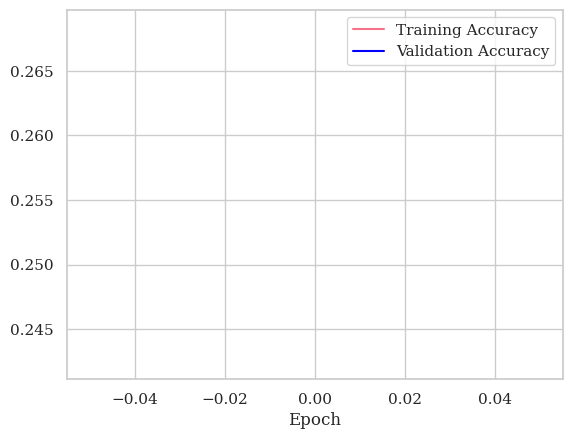

In [35]:
dcn = build_deep_conv_net()
dcn.compile(optimizer=keras.optimizers.Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
dcn, dcn_results = CV_train(dcn, np.expand_dims(X_train,-1), np.expand_dims(X_test,-1), n_epochs=1)

In [36]:
X_train.shape

(3628, 22, 1125)

In [37]:
callbacks = [("lr_scheduler", LRScheduler('CosineAnnealingLR', T_max=n_epochs - 1)),]
eegv4 = NeuralNetClassifier(module=EEGNetv4,
        module__n_chans=22,
        module__n_outputs=4,
        module__n_times=1125,
        module__kernel_length=32,
        module__drop_prob=0.5,
        criterion=torch.nn.CrossEntropyLoss,
        optimizer=torch.optim.Adam,
        optimizer__lr=0.001,
        train_split=None,
        iterator_train__shuffle=True,
        batch_size=32,
        callbacks=callbacks,
        device='cuda' if cuda else 'cpu',
        verbose=verbose
        )

eegv4.fit(X_train, y_train, epochs=1)

  epoch    train_loss      lr     dur
-------  ------------  ------  ------
      1        1.4250  0.0010  2.4488


<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=======================================================================================================================================================
  Layer (type (var_name):depth-idx)                  Input Shape               Output Shape              Param #                   Kernel Shape
  EEGNetv4 (EEGNetv4)                                [1, 22, 1125]             [1, 4]                    --                        --
  ├─Ensure4d (ensuredims): 1-1                       [1, 22, 1125]             [1, 22, 1125, 1]          --                        --
  ├─Rearrange (dimshuffle): 1-2                      [1, 22, 1125, 1]          [1, 1, 22, 1125]          --                        --
  ├─Conv2d (conv_temporal): 1-3                      [1, 1, 22, 1125]          [1, 8, 22, 1126]          256                       [1, 32]
  ├─BatchNorm2d (bnorm_temporal): 1-4                [1, 8, 22, 1126]          [1, 8, 22, 11

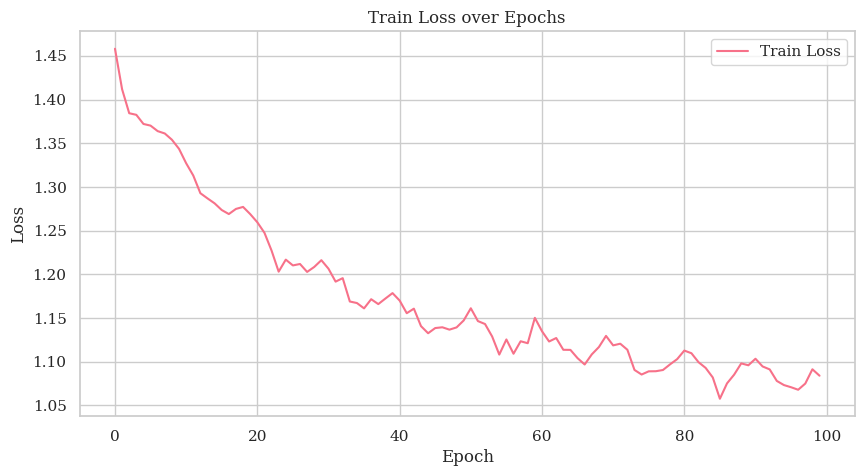

In [104]:
print("Train Accuracy: ", eegv4.score(X_train, np.argmax(y_train, axis=1)))
print("Test Accuracy: ", eegv4.score(X_test, np.argmax(y_test, axis=1)))

train_loss = eegv4.history[:, 'train_loss']
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [38]:
from braindecode.models import *

In [31]:
callbacks = [("lr_scheduler", LRScheduler('CosineAnnealingLR', T_max=n_epochs - 1))]
atcnet = NeuralNetClassifier(module=ATCNet,
        module__n_chans=22,
        module__n_outputs=4,
        module__n_times=1125,
        module__add_log_softmax=False,
        # module__kernel_length=32,
        # module__drop_prob=0.5,
        criterion=torch.nn.CrossEntropyLoss,
        optimizer=torch.optim.Adam,
        optimizer__lr=0.001,
        train_split=None,
        iterator_train__shuffle=True,
        batch_size=32,
        callbacks=callbacks,
        device='cuda' if cuda else 'cpu',
        verbose=verbose
        )
# clf.callbacks.append(TrainEndCheckpoint(dirname=save_dir + f'\\S{subject}'))
atcnet.fit(X_train, y_train, epochs=1)

  epoch    train_loss      lr     dur
-------  ------------  ------  ------
      1        1.3630  0.0010  5.8597
      2        1.2295  0.0009  5.8231


<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_============================================================================================================================================================
  Layer (type (var_name):depth-idx)                       Input Shape               Output Shape              Param #                   Kernel Shape
  ATCNet (ATCNet)                                         [1, 22, 1125]             [1, 4]                    --                        --
  ├─Ensure4d (ensuredims): 1-1                            [1, 22, 1125]             [1, 22, 1125, 1]          --                        --
  ├─Rearrange (dimshuffle): 1-2                           [1, 22, 1125, 1]          [1, 1, 1125, 22]          --                        --
  ├─_ConvBlock (conv_block): 1-3                          [1, 1, 1125, 22]          [1, 32, 20, 1]            --                        --
  │    └─Conv2d (conv1): 2-1                              [1, 1, 11

In [99]:
import matplotlib.pyplot as plt

Train Accuracy:  0.8051267916207276
Test Accuracy:  0.5880462724935732


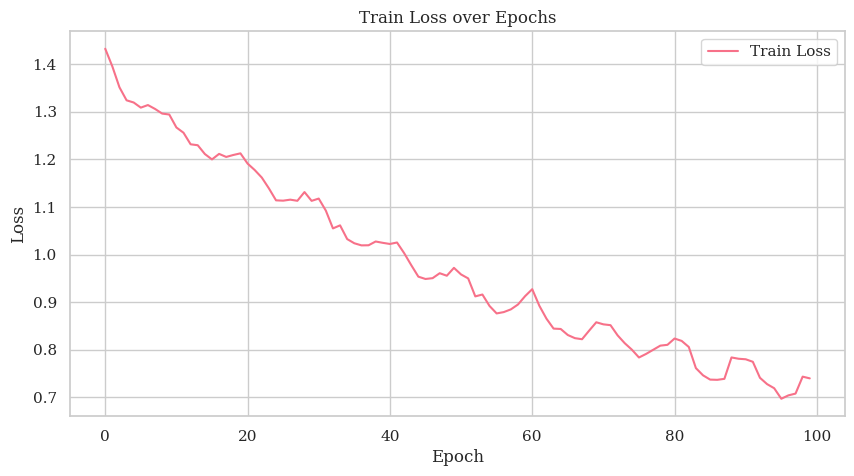

In [100]:
print("Train Accuracy: ", atcnet.score(X_train, np.argmax(y_train, axis=1)))
print("Test Accuracy: ", atcnet.score(X_test, np.argmax(y_test, axis=1)))

train_loss = atcnet.history[:, 'train_loss']
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [32]:
callbacks = [("lr_scheduler", LRScheduler('CosineAnnealingLR', T_max=n_epochs - 1))]
conformer = NeuralNetClassifier(module=EEGConformer,
        module__n_chans=22,
        module__n_outputs=4,
        module__n_times=1125,
        module__final_fc_length='auto',
        module__add_log_softmax=False,
        criterion=torch.nn.CrossEntropyLoss,
        optimizer=torch.optim.Adam,
        optimizer__betas=(0.5, 0.999),
        optimizer__lr=0.001,
        train_split=None,
        iterator_train__shuffle=True,
        batch_size=32,
        callbacks=callbacks,
        device='cuda' if cuda else 'cpu',
        verbose=verbose
        )
# clf.callbacks.append(TrainEndCheckpoint(dirname=save_dir + f'\\S{subject}'))
conformer.fit(X_train, y_train, epochs=2)

  epoch    train_loss      lr     dur
-------  ------------  ------  ------
      1        1.3895  0.0010  6.5622
      2        1.3119  0.0009  6.2430


<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=================================================================================================================================================================
  Layer (type (var_name):depth-idx)                            Input Shape               Output Shape              Param #                   Kernel Shape
  EEGConformer (EEGConformer)                                  [1, 22, 1125]             [1, 4]                    --                        --
  ├─_PatchEmbedding (patch_embedding): 1-1                     [1, 1, 22, 1125]          [1, 69, 40]               --                        --
  │    └─Sequential (shallownet): 2-1                          [1, 1, 22, 1125]          [1, 40, 1, 69]            --                        --
  │    │    └─Conv2d (0): 3-1                                  [1, 1, 22, 1125]          [1, 40, 22, 1101]         1,040                     [1, 25]
  │    │    └─Conv2d (1): 3-2   

In [ ]:
print("Train Accuracy: ", conformer.score(X_train, np.argmax(y_train, axis=1)))
print("Test Accuracy: ", conformer.score(X_test, np.argmax(y_test, axis=1)))

train_loss = conformer.history[:, 'train_loss']
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [39]:
import torch
from braindecode.util import set_random_seeds
from braindecode.models import ShallowFBCSPNet

cuda = torch.cuda.is_available()  # check if GPU is available, if True chooses to use it
device = 'cuda' if cuda else 'cpu'
if cuda:
    torch.backends.cudnn.benchmark = True
seed = 20200220  # random seed to make results reproducible
# Set random seed to be able to reproduce results
set_random_seeds(seed=seed, cuda=cuda)

n_classes=4
# Extract number of chans and time steps from dataset
n_chans = 22
input_window_samples = 1125

model = ShallowFBCSPNet(
    n_chans,
    n_classes,
    input_window_samples=input_window_samples,
    final_conv_length='auto',
)

# Send model to GPU
if cuda:
    model.cuda()
    

c:\Users\Sam\miniconda3\envs\pytgpu\lib\site-packages\braindecode\util.py:51: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(
c:\Users\Sam\miniconda3\envs\pytgpu\lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
c:\Users\Sam\miniconda3\envs\pytgpu\lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


In [42]:
from skorch.callbacks import LRScheduler
from skorch.helper import predefined_split

from braindecode import EEGClassifier

# These values we found good for shallow network:
lr = 0.0625 * 0.01
weight_decay = 0

# For deep4 they should be:
# lr = 1 * 0.01
# weight_decay = 0.5 * 0.001

batch_size = 64
n_epochs = 10

clf = EEGClassifier(
    model,
    criterion=torch.nn.NLLLoss,
    optimizer=torch.optim.AdamW,
    train_split=None,  # using valid_set for validation
    optimizer__lr=lr,
    optimizer__weight_decay=weight_decay,
    batch_size=batch_size,
    callbacks=[
        "accuracy", ("lr_scheduler", LRScheduler('CosineAnnealingLR', T_max=n_epochs - 1)),
    ],
    device=device,
)
# Model training for a specified number of epochs. `y` is None as it is already supplied
# in the dataset.
clf.fit(X_train, np.argmax(y_train, axis=1), epochs=n_epochs)

  epoch    train_accuracy    train_loss      lr     dur
-------  ----------------  ------------  ------  ------
      1            0.4705        1.4304  0.0006  0.7328
      2            0.5201        1.2960  0.0006  0.5355
      3            0.5673        1.2346  0.0006  0.5428
      4            0.5918        1.1808  0.0005  0.5490
      5            0.6166        1.0994  0.0004  0.5151
      6            0.6345        1.0605  0.0003  0.4967
      7            0.6552        1.0357  0.0002  0.5337
      8            0.6651        1.0101  0.0001  0.5168
      9            0.6692        0.9874  0.0000  0.5259
     10            0.6709        0.9876  0.0000  0.5420


<class 'braindecode.classifier.EEGClassifier'>[initialized](
  module_=============================================================================================================================================
  Layer (type (var_name):depth-idx)        Input Shape               Output Shape              Param #                   Kernel Shape
  ShallowFBCSPNet (ShallowFBCSPNet)        [1, 22, 1125]             [1, 4]                    --                        --
  ├─Ensure4d (ensuredims): 1-1             [1, 22, 1125]             [1, 22, 1125, 1]          --                        --
  ├─Rearrange (dimshuffle): 1-2            [1, 22, 1125, 1]          [1, 1, 1125, 22]          --                        --
  ├─CombinedConv (conv_time_spat): 1-3     [1, 1, 1125, 22]          [1, 40, 1101, 1]          36,240                    --
  ├─BatchNorm2d (bnorm): 1-4               [1, 40, 1101, 1]          [1, 40, 1101, 1]          80                        --
  ├─Expression (conv_nonlin_exp): 

In [47]:
from skorch.callbacks import LRScheduler
from skorch.helper import predefined_split

from braindecode import EEGClassifier

# These values we found good for shallow network:
lr = 0.0625 * 0.01
weight_decay = 0

model = EEGNetv4(
    n_chans,
    n_classes,
    input_window_samples=input_window_samples,
    final_conv_length='auto',
)

# For deep4 they should be:
# lr = 1 * 0.01
# weight_decay = 0.5 * 0.001

batch_size = 64
n_epochs = 10

clf = EEGClassifier(
    model,
    criterion=torch.nn.CrossEntropyLoss,
    optimizer=torch.optim.AdamW,
    train_split=None,  # using valid_set for validation
    optimizer__lr=lr,
    optimizer__weight_decay=weight_decay,
    batch_size=batch_size,
    callbacks=[
        "accuracy", ("lr_scheduler", LRScheduler('CosineAnnealingLR', T_max=n_epochs - 1)),
    ],
    device=device,
)
# Model training for a specified number of epochs. `y` is None as it is already supplied
# in the dataset.
clf.fit(X_train, np.argmax(y_train, axis=1), epochs=n_epochs)

c:\Users\Sam\miniconda3\envs\pytgpu\lib\site-packages\braindecode\models\base.py:23: UserWarning: EEGNetv4: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(


  epoch    train_accuracy    train_loss      lr     dur
-------  ----------------  ------------  ------  ------
      1            0.2585        1.4131  0.0006  1.2933
      2            0.2605        1.3738  0.0006  0.8957
      3            0.2660        1.3327  0.0006  0.9030
      4            0.2817        1.3041  0.0005  0.8793
      5            0.3415        1.2657  0.0004  0.8811
      6            0.3950        1.2468  0.0003  0.8904
      7            0.4438        1.2231  0.0002  0.8908
      8            0.4713        1.2120  0.0001  0.8951
      9            0.4791        1.2195  0.0000  0.8983
     10            0.4848        1.2170  0.0000  0.8877


<class 'braindecode.classifier.EEGClassifier'>[initialized](
  module_=======================================================================================================================================================
  Layer (type (var_name):depth-idx)                  Input Shape               Output Shape              Param #                   Kernel Shape
  EEGNetv4 (EEGNetv4)                                [1, 22, 1125]             [1, 4]                    --                        --
  ├─Ensure4d (ensuredims): 1-1                       [1, 22, 1125]             [1, 22, 1125, 1]          --                        --
  ├─Rearrange (dimshuffle): 1-2                      [1, 22, 1125, 1]          [1, 1, 22, 1125]          --                        --
  ├─Conv2d (conv_temporal): 1-3                      [1, 1, 22, 1125]          [1, 8, 22, 1126]          512                       [1, 64]
  ├─BatchNorm2d (bnorm_temporal): 1-4                [1, 8, 22, 1126]          [1, 8, 22, 112

In [49]:
from skorch.callbacks import LRScheduler
from skorch.helper import predefined_split

from braindecode import EEGClassifier

# These values we found good for shallow network:
lr = 0.0625 * 0.01
weight_decay = 0

model = EEGNetv1(
    n_chans,
    n_classes,
    input_window_samples=input_window_samples,
    final_conv_length='auto',
)

# For deep4 they should be:
# lr = 1 * 0.01
# weight_decay = 0.5 * 0.001

batch_size = 64
n_epochs = 10

clf = EEGClassifier(
    model,
    criterion=torch.nn.CrossEntropyLoss,
    optimizer=torch.optim.AdamW,
    train_split=None,  # using valid_set for validation
    optimizer__lr=lr,
    optimizer__weight_decay=weight_decay,
    batch_size=batch_size,
    callbacks=[
        "accuracy", ("lr_scheduler", LRScheduler('CosineAnnealingLR', T_max=n_epochs - 1)),
    ],
    device=device,
)
# Model training for a specified number of epochs. `y` is None as it is already supplied
# in the dataset.
clf.fit(X_train, np.argmax(y_train, axis=1), epochs=n_epochs)

c:\Users\Sam\miniconda3\envs\pytgpu\lib\site-packages\braindecode\models\base.py:23: UserWarning: EEGNetv1: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
c:\Users\Sam\miniconda3\envs\pytgpu\lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss      lr     dur
-------  ----------------  ------------  ------  ------
      1            0.2756        1.8264  0.0006  2.4585
      2            0.2894        1.6001  0.0006  1.6646
      3            0.2958        1.5036  0.0006  1.6534
      4            0.3236        1.4524  0.0005  1.6517
      5            0.3360        1.4386  0.0004  1.6585
      6            0.3465        1.4104  0.0003  1.6472
      7            0.3569        1.3946  0.0002  1.6756
      8            0.3569        1.4064  0.0001  1.6787
      9            0.3580        1.3777  0.0000  1.7095
     10            0.3567        1.4018  0.0000  1.6443


<class 'braindecode.classifier.EEGClassifier'>[initialized](
  module_=============================================================================================================================================
  Layer (type (var_name):depth-idx)        Input Shape               Output Shape              Param #                   Kernel Shape
  EEGNetv1 (EEGNetv1)                      [1, 22, 1125]             [1, 4]                    --                        --
  ├─Ensure4d (ensuredims): 1-1             [1, 22, 1125]             [1, 22, 1125, 1]          --                        --
  ├─Conv2d (conv_1): 1-2                   [1, 22, 1125, 1]          [1, 16, 1125, 1]          368                       [1, 1]
  ├─BatchNorm2d (bnorm_1): 1-3             [1, 16, 1125, 1]          [1, 16, 1125, 1]          32                        --
  ├─Expression (elu_1): 1-4                [1, 16, 1125, 1]          [1, 16, 1125, 1]          --                        --
  ├─Expression (permute_1): 1-

In [50]:
from skorch.callbacks import LRScheduler
from skorch.helper import predefined_split

from braindecode import EEGClassifier

# These values we found good for shallow network:
lr = 0.0625 * 0.01
weight_decay = 0

model = Deep4Net(
    n_chans,
    n_classes,
    input_window_samples=input_window_samples,
    final_conv_length='auto',
)

# For deep4 they should be:
# lr = 1 * 0.01
# weight_decay = 0.5 * 0.001

batch_size = 64
n_epochs = 10

clf = EEGClassifier(
    model,
    criterion=torch.nn.CrossEntropyLoss,
    optimizer=torch.optim.AdamW,
    train_split=None,  # using valid_set for validation
    optimizer__lr=lr,
    optimizer__weight_decay=weight_decay,
    batch_size=batch_size,
    callbacks=[
        "accuracy", ("lr_scheduler", LRScheduler('CosineAnnealingLR', T_max=n_epochs - 1)),
    ],
    device=device,
)
# Model training for a specified number of epochs. `y` is None as it is already supplied
# in the dataset.
clf.fit(X_train, np.argmax(y_train, axis=1), epochs=n_epochs)

c:\Users\Sam\miniconda3\envs\pytgpu\lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
c:\Users\Sam\miniconda3\envs\pytgpu\lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss      lr     dur
-------  ----------------  ------------  ------  ------
      1            0.2500        1.7962  0.0006  1.0800
      2            0.2729        1.6900  0.0006  0.6149
      3            0.2726        1.6404  0.0006  0.6008
      4            0.2947        1.5644  0.0005  0.5750
      5            0.2718        1.5405  0.0004  0.5942
      6            0.2966        1.4835  0.0003  0.5547
      7            0.2878        1.4548  0.0002  0.5731
      8            0.3139        1.4383  0.0001  0.5606
      9            0.3134        1.4353  0.0000  0.5667
     10            0.3120        1.4336  0.0000  0.5864


<class 'braindecode.classifier.EEGClassifier'>[initialized](
  module_=============================================================================================================================================
  Layer (type (var_name):depth-idx)        Input Shape               Output Shape              Param #                   Kernel Shape
  Deep4Net (Deep4Net)                      [1, 22, 1125]             [1, 4]                    --                        --
  ├─Ensure4d (ensuredims): 1-1             [1, 22, 1125]             [1, 22, 1125, 1]          --                        --
  ├─Rearrange (dimshuffle): 1-2            [1, 22, 1125, 1]          [1, 1, 1125, 22]          --                        --
  ├─CombinedConv (conv_time_spat): 1-3     [1, 1, 1125, 22]          [1, 25, 1116, 1]          14,025                    --
  ├─BatchNorm2d (bnorm): 1-4               [1, 25, 1116, 1]          [1, 25, 1116, 1]          50                        --
  ├─Expression (conv_nonlin): 1-5 

In [72]:
from skorch.callbacks import LRScheduler
from skorch.helper import predefined_split

from braindecode import EEGClassifier

# These values we found good for shallow network:
lr = 0.0625 * 0.01
weight_decay = 0

model = EEGITNet(

    n_classes,
        n_chans,
    input_window_samples=input_window_samples,
)

# For deep4 they should be:
# lr = 1 * 0.01
# weight_decay = 0.5 * 0.001

batch_size = 64
n_epochs = 10

clf = EEGClassifier(
    model,
    criterion=torch.nn.CrossEntropyLoss,
    optimizer=torch.optim.AdamW,
    train_split=None,  # using valid_set for validation
    optimizer__lr=lr,
    optimizer__weight_decay=weight_decay,
    batch_size=batch_size,
    callbacks=[
        "accuracy", ("lr_scheduler", LRScheduler('CosineAnnealingLR', T_max=n_epochs - 1)),
    ],
    device=device,
)
# Model training for a specified number of epochs. `y` is None as it is already supplied
# in the dataset.
clf.fit(X_train, np.argmax(y_train, axis=1), epochs=n_epochs)

c:\Users\Sam\miniconda3\envs\pytgpu\lib\site-packages\braindecode\models\base.py:23: UserWarning: EEGITNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
c:\Users\Sam\miniconda3\envs\pytgpu\lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss      lr     dur
-------  ----------------  ------------  ------  ------
      1            0.3170        1.4066  0.0006  1.7924
      2            0.3327        1.3478  0.0006  1.5226
      3            0.3578        1.3083  0.0006  1.5658
      4            0.3784        1.2867  0.0005  1.5178
      5            0.3875        1.2661  0.0004  1.5270
      6            0.4049        1.2603  0.0003  1.5235
      7            0.4008        1.2277  0.0002  1.5432
      8            0.4033        1.2295  0.0001  1.5351
      9            0.4033        1.2265  0.0000  1.5414
     10            0.4021        1.2216  0.0000  1.5379


<class 'braindecode.classifier.EEGClassifier'>[initialized](
  module_=======================================================================================================================================================
  Layer (type (var_name):depth-idx)                  Input Shape               Output Shape              Param #                   Kernel Shape
  EEGITNet (EEGITNet)                                [1, 22, 1125]             [1, 4]                    --                        --
  ├─Sequential (input_preprocess): 1-1               [1, 22, 1125]             [1, 1, 22, 1125]          --                        --
  │    └─Ensure4d (0): 2-1                           [1, 22, 1125]             [1, 22, 1125, 1]          --                        --
  │    └─Rearrange (1): 2-2                          [1, 22, 1125, 1]          [1, 1, 22, 1125]          --                        --
  ├─_InceptionBlock (inception_block): 1-2           [1, 1, 22, 1125]          [1, 14, 1, 1125]   

In [80]:
loss = []
acc = []
for a in clf.history:
    loss.append(a['train_loss'])    
    acc.append(a['train_accuracy'])

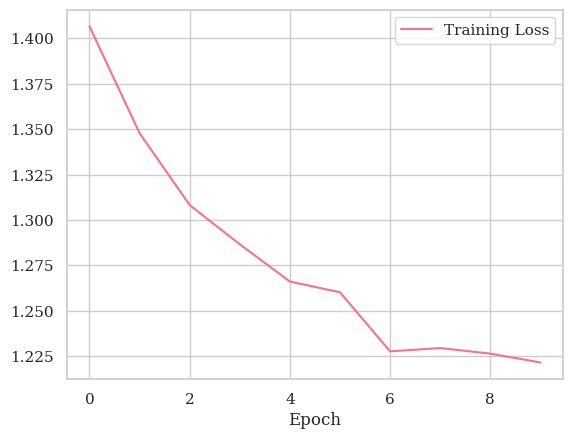

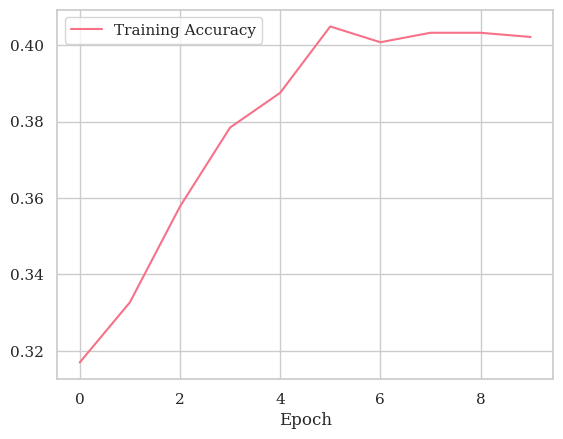

In [81]:
plt.plot(loss, label='Training Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()
plt.plot(acc, label='Training Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [83]:
clf.score(X_test, np.argmax(y_test, axis=1))

0.3232647814910026

In [30]:
# subjects_windows_dataset = windows_dataset.split('subject')
# n_subjects = len(subjects_windows_dataset.items())
# avg_accuracy = 0

# # iterate over each subject (9 subjects)
# for subject, window_dataset in subjects_windows_dataset.items():
#         # evaluate the model by test accuracy for "Hold-Out" strategy
#         train_dataset = windows_dataset.split('session')['0train']
#         test_dataset = windows_dataset.split('session')['1test']

#         train_X = SliceDataset(train_dataset, idx=0)
#         train_y = SliceDataset(train_dataset, idx=1)
#         test_X = SliceDataset(test_dataset, idx=0)
#         test_y = SliceDataset(test_dataset, idx=1)

#         # create the classifier
#         callbacks = [("lr_scheduler", LRScheduler('CosineAnnealingLR', T_max=n_epochs - 1))]
#         clf = NeuralNetClassifier(module=EEGNetv4,
#                 module__n_chans=n_channels,
#                 module__n_outputs=n_classes,
#                 module__n_times=n_times,
#                 module__kernel_length=32,
#                 module__drop_prob=0.5,
#                 criterion=torch.nn.CrossEntropyLoss,
#                 optimizer=torch.optim.Adam,
#                 optimizer__lr=lr,
#                 train_split=None,
#                 iterator_train__shuffle=True,
#                 batch_size=batch_size,
#                 callbacks=callbacks,
#                 device='cuda' if cuda else 'cpu',
#                 verbose=verbose
#                 )
#         clf.callbacks.append(TrainEndCheckpoint(dirname=save_dir + f'\\S{subject}'))
#         clf.fit(train_X, y=train_y, epochs=n_epochs)
        
#         # calculate test accuracy for subject
#         test_accuracy = clf.score(test_X, y=test_y)
#         avg_accuracy += test_accuracy

#         print(f"Subject{subject} test accuracy: {(test_accuracy * 100):.4f}%")
# print(f"Average test accuracy: {(avg_accuracy / n_subjects * 100):.4f}%")

  epoch    train_loss      lr     dur
-------  ------------  ------  ------
      1        1.4392  0.0010  1.4764
      2        1.3972  0.0009  1.0143
      3        1.3840  0.0007  1.0089
      4        1.3505  0.0003  1.0462
      5        1.3401  0.0001  1.0468
      6        1.3344  0.0000  1.0407
Subject1 test accuracy: 27.4691%
  epoch    train_loss      lr     dur
-------  ------------  ------  ------
      1        1.4503  0.0010  1.0222
      2        1.3869  0.0009  1.0487
      3        1.3628  0.0007  1.0566
      4        1.3417  0.0003  1.0457
      5        1.3414  0.0001  1.0546
      6        1.3285  0.0000  1.0124
Subject2 test accuracy: 25.2701%
  epoch    train_loss      lr     dur
-------  ------------  ------  ------
      1        1.4802  0.0010  1.0435
      2        1.4096  0.0009  1.0270
      3        1.3810  0.0007  1.0492
      4        1.3518  0.0003  1.0592
      5        1.3569  0.0001  1.0346
      6        1.3532  0.0000  1.0044
Subject3 test accuracy